In [1]:
import time
import os
import math
import numpy as np
import cv2
import pandas as pd
import pyautogui as pa
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
#import statsmodels.api as sm
#from statsmodels.stats.multitest import fdrcorrection
import pylab as P

from lib.auto_GUI.auto_GUI_base import AutoGUIBase
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.file.TIF import *
from lib.analysis.ROI_identification import *
from lib.file.ROI_writer import ROIFileWriter
from lib.file.ROI_reader import ROIFileReader
from lib.file.TSV import RegionExporter
#from lib.analysis.align import ImageAlign
from lib.file.DAT import TracesDAT
from lib.trace import Tracer
from lib.utilities import *
from lib.analysis.laminar_dist import *

In [2]:
############## QUESTION: ##################################
# Does PV IN velocity jump abruptly at barrel/layer boundary?
# analyze velocity BUT:
#            - chunked by barrel for intralaminar CVs
#            - chunked by layer for interlaminar CVs
# 
###########################################################

In [3]:
# Load data, not from Drive for Desktop since PhotoZ complains about loading zda from Drive
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/Kate's/"
data_dir = 'C:/Users/jjudg/OneDrive/Desktop/'
csv_filename = 'raw_velocity_data_JJ_KS_compare_v7.csv'

synaptic_column = "Kate's Synaptic"
latency_column = "Kate's Mono Latency" #'Latency_Mono_Raw'

# load the all-data CSV dir
df = pd.read_csv(data_dir + csv_filename)
df = pd.DataFrame(df)
df

,Date,Id,Genotype,Birthdate,Age_Days,Sex,Tx,Tx_Start,Slice_Loc_Run,Trial_x_Time,...,Latency_Mono_Raw,Kate's Mono Latency,Mono_Resp_Start_Time,Mono_Resp_End_Time,Layer,Distance,window start,window len,window end,Unnamed: 35
0,10_02_2020,471989,PV,08_04_2020,66,M,Run_Control,09_04_2020,02_01_05,5x15,...,47.2902,47.2803,46.5,50.5,2_3,2.76,93,8,101,NaN
1,10_02_2020,471989,PV,08_04_2020,66,M,Run_Control,09_04_2020,02_01_05,5x15,...,47.2542,47.2422,46.5,50.5,2_3,5.82,93,8,101,NaN
2,10_02_2020,471989,PV,08_04_2020,66,M,Run_Control,09_04_2020,02_01_05,5x15,...,47.3070,47.2978,46.5,50.5,2_3,8.78,93,8,101,NaN
3,10_02_2020,471989,PV,08_04_2020,66,M,Run_Control,09_04_2020,02_01_05,5x15,...,47.5374,47.5344,46.5,50.5,2_3,11.63,93,8,101,NaN
4,10_02_2020,471989,PV,08_04_2020,66,M,Run_Control,09_04_2020,02_01_05,5x15,...,47.4508,47.4433,46.5,50.5,4,14.74,93,8,101,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1782,09_06_2021,5596,FXR1,07_24_2021,47,F,FXR1_Control,NaN,08_01_04,5x15,...,50.5024,50.4962,49.5,53.0,2_3_D,31.04,99,7,106,NaN
1783,09_06_2021,5596,FXR1,07_24_2021,47,F,FXR1_Control,NaN,08_01_04,5x15,...,50.9913,50.9979,49.5,53.0,2_3_D,34.04,99,7,106,NaN
1784,09_06_2021,5596,FXR1,07_24_2021,47,F,FXR1_Control,NaN,08_01_04,5x15,...,50.9794,50.9916,49.5,53.0,2_3_D,37.28,99,7,106,NaN
1785,09_06_2021,5596,FXR1,07_24_2021,47,F,FXR1_Control,NaN,08_01_04,5x15,...,51.7702,46.2476,49.5,53.0,2_3_D,40.46,99,7,106,NaN


In [4]:
# Fill in more of synapse_count_map from file
dir_name = 'Choosing trajectories'
filename = 'raw_velocity_data_JJ.csv'

filename_combined = data_dir + csv_filename

synapse_count_map = {}

df_combined = pd.read_csv(filename_combined)
df_combined = pd.DataFrame(df_combined, columns=['Date', 'Slice_Loc_Run',
                              'Stim_Layer', 'Laminar', 'ROI_Id', 'Synaptic', 'Kate\'s Synaptic',
                               'Latency_Mono_Raw', 'Kate\'s Mono Latency', 'Distance'])
print(df_combined)
for date in df_combined.Date.unique():
    cv_subset_date = df_combined[(df_combined['Date'] == date)]
    for rec_id in cv_subset_date.Slice_Loc_Run.unique():
        cv_subset_rec_id = cv_subset_date[(cv_subset_date['Slice_Loc_Run'] == rec_id)]
        for laminar_val in cv_subset_rec_id.Laminar.unique():
            cv_subset_lam = cv_subset_rec_id[(cv_subset_rec_id['Laminar'] == laminar_val)]
            for layer_val in cv_subset_lam.Stim_Layer.unique():
                plot_key = date + " " + rec_id + " " + laminar_val + " " + layer_val
                cv_subset = cv_subset_lam[(cv_subset_lam['Stim_Layer'] == layer_val)]
                if plot_key not in synapse_count_map:
                    synapse_count_map[plot_key] = {0: [], 1: [], 2:[]}
                    for idx, row in cv_subset.iterrows():
                        roi_id_0 = int(row['ROI_Id']) - 1
                        if type(row[synaptic_column]) == str:
                            
                            if "Mono" in row[synaptic_column]:
                                # print(roi_id_0, 1)
                                synapse_count_map[plot_key][1].append(roi_id_0)
                            elif "Disyn" in row[synaptic_column]:
                                # print(roi_id_0, 2)
                                synapse_count_map[plot_key][2].append(roi_id_0)
                            elif "Dir" in row[synaptic_column]:
                                synapse_count_map[plot_key][0].append(roi_id_0)
                

            Date Slice_Loc_Run Stim_Layer Laminar  ROI_Id      Synaptic  \
0     10_02_2020      02_01_05        2_3   Inter       1   Direct_resp   
1     10_02_2020      02_01_05        2_3   Inter       2   Direct_resp   
2     10_02_2020      02_01_05        2_3   Inter       3   Direct_resp   
3     10_02_2020      02_01_05        2_3   Inter       4   Direct_resp   
4     10_02_2020      02_01_05        2_3   Inter       5  Monosynaptic   
...          ...           ...        ...     ...     ...           ...   
1782  09_06_2021      08_01_04        2_3   Intra      10       No_resp   
1783  09_06_2021      08_01_04        2_3   Intra      11    Disynaptic   
1784  09_06_2021      08_01_04        2_3   Intra      12    Disynaptic   
1785  09_06_2021      08_01_04        2_3   Intra      13    Disynaptic   
1786  09_06_2021      08_01_04        2_3   Intra      14    Disynaptic   

     Kate's Synaptic  Latency_Mono_Raw  Kate's Mono Latency  Distance  
0        Direct_resp       

#  10_02_2020 02_01_05 Inter 2_3


NameError: name 'sm' is not defined

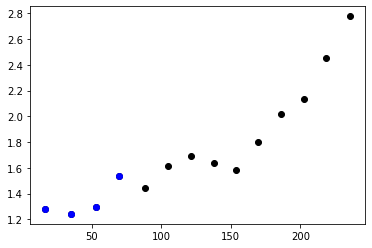

In [5]:
# load original CSV
        
#df = pd.read_csv(filename)
#df = pd.DataFrame(df, columns=['Date', 'Age_Days', 'Sex', 'Tx', 'Slice_Loc_Run',
#                              'Trial_x_Time', 'Stim_Intensity', 'Cx', 'n_Pulses',
#                              'Stim_Layer', 'Laminar', 'ROI_Id', 'SNR', 
#                               'Latency_Mono_Raw', 'Distance'])

df = df_combined

df['Latency_Calc'] = df[latency_column] - 46.0  # 46 ms is stim time
df.drop(df[df['Latency_Calc'] <= 0].index, inplace=True)  # negative values are non-physical

# 6 um per pixel on new rig (see https://github.com/john-judge/TSM-to-ZDA/issues/12)
df['Distance'] *= 6.0

# targets to plot
laminar_val_target = "Inter"
layer_val_target = "5"
plot_all = True  # overrides above 2 lines
total_points = 0
min_roi_count = 7  # fewer than 7 ROIs excludes velocity measurement
unplotted_plot_keys = []

velocity_measurements = {}
colors = ['b', 'r', 'g']
# for each recording/laminar/direction measurement, plot latency vs distance
for date in df.Date.unique():
    cv_subset_date = df[(df['Date'] == date)]
    for rec_id in cv_subset_date.Slice_Loc_Run.unique():
        cv_subset_rec_id = cv_subset_date[(cv_subset_date['Slice_Loc_Run'] == rec_id)]
        for laminar_val in cv_subset_rec_id.Laminar.unique():
            cv_subset_lam = cv_subset_rec_id[(cv_subset_rec_id['Laminar'] == laminar_val)]
            for layer_val in cv_subset_lam.Stim_Layer.unique():
                plot_key = date + " " + rec_id + " " + laminar_val + " " + layer_val
                if plot_all or (laminar_val_target == laminar_val and layer_val_target == layer_val):
                    cv_subset = cv_subset_lam[(cv_subset_lam['Stim_Layer'] == layer_val)]
                    plt.clf()
                    plt.scatter(cv_subset['Distance'], 
                                cv_subset['Latency_Calc'],
                                c='black')
                    print("# ", plot_key)
                    if plot_key in synapse_count_map:

                        # analyze and plot each synapse-count group separately
                        reg_lines = []
                        for i_synap in [0, 1, 2]:
                            ind_list = synapse_count_map[plot_key][i_synap]
                            for k in range(len(ind_list)-1, -1, -1):
                                if ind_list[k] > len(cv_subset['Distance'])-1:
                                    del ind_list[k]
                            try:
                                syn_cv_subset = cv_subset.iloc[ind_list]
                            except Exception as e:
                                print(ind_list, e)
                            dist = np.array(syn_cv_subset['Distance']).reshape(-1, 1)
                            latency = np.array(syn_cv_subset['Latency_Calc']).reshape(-1, 1)
                            plt.scatter(dist, latency, c=colors[i_synap])

                            if dist.size > 1:
                                regr = linear_model.LinearRegression()
                                regr.fit(dist, latency)
                                params = np.append(regr.intercept_, regr.coef_)
                                y_pred = regr.predict(dist)
                                velocity = round(1 / regr.coef_[0][0], 5)
                                
                                # statistical significance analysis
                                #define predictor and response variables
                                y = syn_cv_subset['Latency_Calc']
                                x = syn_cv_subset['Distance']

                                #add constant to predictor variables
                                x = sm.add_constant(x)

                                #fit linear regression model
                                model = sm.OLS(y, x).fit()

                                pvalue = model.pvalues.loc['Distance']
                                reg_lines.append([dist, y_pred, velocity, i_synap, pvalue])
                                
                                if velocity > 0 and dist.shape[0] > min_roi_count:
                                    vel_key = laminar_val + " " + layer_val
                                    if vel_key not in velocity_measurements:
                                        velocity_measurements[vel_key] = {}
                                    if i_synap not in velocity_measurements[vel_key]:
                                        velocity_measurements[vel_key][i_synap] = {"Velocity": [], "P-value": [], "Metadata": []}
                                    velocity_measurements[vel_key][i_synap]["Velocity"].append(velocity)
                                    velocity_measurements[vel_key][i_synap]["P-value"].append(pvalue)
                                    velocity_measurements[vel_key][i_synap]["Metadata"].append(date + " " + rec_id)
                                    

                        plt.legend(["Other","Direct Stim", "Monosynaptic", "Disynaptic"])
                        for rl in reg_lines:
                            dist, y_pred, velocity, i_synap, pvalue = rl
                            plt.plot(dist, y_pred, c='b')
                            print(str(i_synap) + "-synapse Velocity:", round(velocity, 2), "um / ms")
                            print("\tP-value:", pvalue)
                    else:
                        unplotted_plot_keys.append(plot_key)

                    plt.title(date + " Recording " + rec_id + ", " + laminar_val + "laminar in L" + layer_val)
                    plt.xlabel('Distance (um)')
                    plt.ylabel('Latency (ms)')
                    total_points += len(cv_subset['Distance'])
                    print("Num points:", len(cv_subset['Distance']))
                    plt.show()
                    
print("total_points:", total_points)
print("Unplotted plot keys:", unplotted_plot_keys)

In [ ]:
# Make box and whisker plots comparing velocities by interlaminar, intralaminar, and stimulation site 

# vel_key is laminar direction[dir*] + stim layer
#    * 2/3 or 5 direction if inter from 4

# Plot 1: 5 bars
plot_1_data = {}
for vel_key in velocity_measurements:
    if 1 not in velocity_measurements[vel_key]:
        continue
    vel_data = velocity_measurements[vel_key][1]["Velocity"]  # monosyn only
    laminar, layer = vel_key.split(" ")
    laminar = laminar[:5]
    new_key = laminar + "_" + layer
    if new_key not in plot_1_data:
        plot_1_data[new_key] = []
    plot_1_data[new_key] += vel_data
plt.bar([i for i in range(len(plot_1_data.keys()))], 
        [np.mean(plot_1_data[k]) for k in plot_1_data],
        tick_label=[k for k in plot_1_data],
        yerr=[np.std(plot_1_data[k])/np.sqrt(len(plot_1_data[k])) for k in plot_1_data],
        error_kw={"capsize": 5.0})
plt.ylabel("Velocity (um/msec)")
plt.title("Velocity Comparisons")
plt.show()

# group data for more specific comparisons
plot_2_data = {}
plot_3_data = {}
for vel_key in velocity_measurements:
    if 1 not in velocity_measurements[vel_key]:
        continue
    vel_data = velocity_measurements[vel_key][1]["Velocity"]  # monosyn only
    laminar, layer = vel_key.split(" ")
    
    if laminar not in plot_2_data:
        plot_2_data[laminar] = []
    plot_2_data[laminar] += vel_data
    
    if "Inter" in laminar:
        if layer in ["2_3", "5"]:
            layer = "L2/3, L5"
        elif layer == "4":
            layer = "L4"
        if layer not in plot_3_data:
            plot_3_data[layer] = []
        plot_3_data[layer] += vel_data
    
# Plot 2: box and whiskers comparing inter vs intra
P.figure()
labels = ['Interlaminar', 'Intralaminar']
bp = P.boxplot([plot_2_data[lbl[:5]] for lbl in labels],
               labels=labels,
               sym="")  # hides fliers
for i in range(len(labels)):
    lbl = labels[i]
    y = plot_2_data[lbl[:5]]
    x = np.random.normal(1+i, 0.04, size=len(y))
    P.plot(x, y, 'r.', alpha=0.2)
plt.ylabel("Velocity (um/msec)")
plt.title("Velocity Comparison: Laminar Directions")
P.show()

# Plot 3: box and whisker trajectories only inter, comparing L4 vs L2/3, L5
P.figure()
labels = ["L2/3, L5", 'L4']
bp = P.boxplot([plot_3_data[lbl] for lbl in labels],
               labels=labels,
               sym="")  # hides fliers
for i in range(len(labels)):
    lbl = labels[i]
    y = plot_3_data[lbl]
    x = np.random.normal(1+i, 0.04, size=len(y))
    P.plot(x, y, 'r.', alpha=0.2)
plt.ylabel("Velocity (um/msec)")
plt.ylabel("Stimulation Layer")
plt.title("Velocity Comparison: Stimulation Layer")
P.show()
